In [1]:
#import and read in data
import numpy as np
import pandas
#supress warning generated by random.choice
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data=pandas.read_csv('pres16results.csv')

In [2]:
#Combine all counties
combinedCounties=[]
countyPopulation=[]
countyWinner=[]
countyState=[]
skip=0
for x in range(0,len(data)):
    for y in range(0,len(combinedCounties)):
        if (data['county'][x]==combinedCounties[y] or pandas.isnull(data['county'][x])==True):
            skip=1
    if (skip==0):
        combinedCounties.append(data['county'][x])
        countyPopulation.append(data['total_votes'][x])
        countyWinner.append(data['lead'][x])
        countyState.append(data['st'][x])
    skip=0

In [3]:
del(combinedCounties[0])
del(countyState[0])
del(countyPopulation[0])
del(countyWinner[0])
randomOrder=[]
for x in range(0,len(combinedCounties)):
    randomOrder.append(x)
np.random.shuffle(randomOrder)

In [4]:
learnSize=0.8

In [5]:
numHillary=[]
numTrump=[]
for x in range(0,int(learnSize*len(combinedCounties))):
    if (countyWinner[randomOrder[x]]=='Hillary Clinton'):
        numHillary.append(countyPopulation[randomOrder[x]]);
    if (countyWinner[randomOrder[x]]=='Donald Trump'):
        numTrump.append(countyPopulation[randomOrder[x]]);

In [6]:
#Finds intersection of two normal distrubtutions
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

In [7]:
#FINDS INTERSECTION OF NORMAL DISTRUBTION OF POPULATION OF COUNTIES THAT VOTED HILL VS TRUMP
intersection=solve(np.mean(numHillary),np.mean(numTrump),np.std(numHillary),np.std(numHillary))[0]
print(intersection)

100493.658306


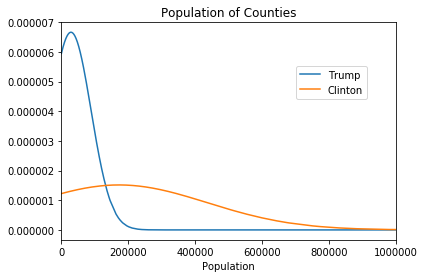

In [8]:
import scipy.stats as stats
import pylab as pl
import matplotlib.pyplot as plt
newData=sorted(numTrump)
newDataH=sorted(numHillary)
fit = stats.norm.pdf(newData, np.mean(newData), np.std(newData))
fitH=stats.norm.pdf(newDataH,np.mean(newDataH),np.std(newDataH))
pl.plot(newData,fit,label='Trump')
pl.plot(newDataH,fitH,label='Clinton')
#plt.ylabel('Accuracy')
plt.xlabel('Population')
plt.title('Population of Counties')
plt.legend(bbox_to_anchor=(0.7, 0.8), loc=2, borderaxespad=0.)
axes = plt.gca()
axes.set_xlim([0,1000000])
pl.show()

In [9]:
popRange=0.75 # RANGE THAT POPULATION MUST BE TO FACTOR INTO PROBABILITY
changeRate=.95 # AMOUNT PROBABILITY IS AFFECTED IF POP IS AFFECTING IT (0,1)

In [10]:
uniqueStates=[]#['initialize',0,0,0]]
totalStates=0
numHillary=0
numTrump=0
skip=False
for x in range(0,int(learnSize*len(combinedCounties))):
    for y in range(0,len(uniqueStates)):
        if (uniqueStates[y][0] == countyState[randomOrder[x]]):
            skip=True
            uniqueStates[y][1]+=1
            if (countyWinner[randomOrder[x]]=='Donald Trump'):
                uniqueStates[y][3]+=1
            else:
                uniqueStates[y][2]+=1
    if (skip==False):
        uniqueStates.append([countyState[randomOrder[x]],1,0,0])
        if (countyWinner[randomOrder[x]]=='Donald Trump'):
            uniqueStates[len(uniqueStates)-1][3]+=1
        else:
            uniqueStates[len(uniqueStates)-1][2]+=1
    skip=False

In [11]:
bothCand=['Hillary Clinton','Donald Trump']
numCorrect=0
totalChecked=0
runningTotal=[]

for x in range(int(learnSize*len(combinedCounties)),len(combinedCounties)):
    state=countyState[randomOrder[x]]
    numberOfStates=0
    hillStates=0
    trumpStates=0
    guess=''
    rates=[]
    for y in range(0,len(uniqueStates)):
        if (state==uniqueStates[y][0]):
            numberOfStates=uniqueStates[y][1]
            hillStates=uniqueStates[y][2]
            trumpStates=uniqueStates[y][3]

    if (numberOfStates>0):
        rateOfTrump=trumpStates/numberOfStates
        rateOfHillary=hillStates/numberOfStates
        rates.append(rateOfHillary)
        rates.append(rateOfTrump)
        population=countyPopulation[randomOrder[x]]


        #OBVIOUS GUESSES
        if (rateOfTrump==1.0):
            guess='Donald Trump'
        elif(rateOfHillary==1.0):
            guess='Hillary Clinton'

            
            
        #TO DO: =================================================================
        #CHANGE changeRate to depend on population/rate difference===============
        #========================================================================
            
            
        #USING POPULATION
        elif (rateOfTrump>rateOfHillary):
            if (population<intersection/popRange):
                
                changeValue = rates[0]*changeRate*population/intersection
                
                
                changeValue=rates[0]*changeRate
                rates[0]=rates[0]-changeValue
                rates[1]=rates[1]+changeValue

            elif(population>intersection*popRange):
                changeValue=rates[1]*changeRate
                rates[1]=rates[1]-changeValue
                rates[0]=rates[0]+changeValue

            
            guess=np.random.choice(bothCand,1,p=rates)



        elif (rateOfTrump<rateOfHillary):
            if (population>intersection*popRange):
                changeValue=rates[1]*changeRate
                rates[1]=rates[1]-changeValue
                rates[0]=rates[0]+changeValue

            elif(population<intersection/popRange):
                changeValue=rates[0]*changeRate
                rates[0]=rates[0]-changeValue
                rates[1]=rates[1]+changeValue

            
            guess=np.random.choice(bothCand,1,p=rates)

        #IF RATES EQUAL
        else:
            if (population>intersection):
                chnageValue=rates[1]*changeRate
                rates[1]=rates[1]-changeValue
                rates[0]=rates[0]+changeValue
            else:
                changeValue=rates[0]*changeRate
                rates[0]=rates[0]-changeValue
                rates[1]=rates[1]+changeValue
            guess=np.random.choice(bothCand,1,p=rates)
    #IF NO PREVIOUS COUNTIES IN STATE HAVE BEEN RECORDED => GUESS
    else:
        random=np.random.randint(0,2)
        if(random==0):
            guess='Hillary Clinton'
        elif(random==1):
            guess='Donald Trump'

    if(guess==countyWinner[randomOrder[x]]):
        numCorrect+=1
    totalChecked+=1

    runningTotal.append((numCorrect*100)/totalChecked)

In [12]:
#maxi=0
#for x in range(0,len(total)):
#    print(total[x])
#    if (total[x][0]>total[maxi][0]):
#        maxi=x
#print(total[maxi])

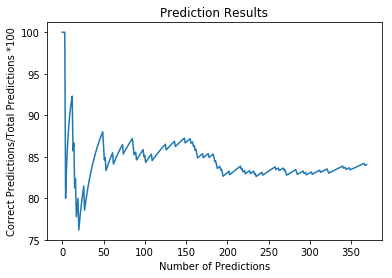

In [13]:
import matplotlib.pyplot as plt
plt.plot(runningTotal)
plt.ylabel('Correct Predictions/Total Predictions *100')
plt.xlabel('Number of Predictions')
plt.title('Prediction Results')
plt.show()

In [17]:
totalAvg=[]
for df in range(0,10):
    avg=[]
    learnSize=.8
    for p in range(0,len(combinedCounties)):
        #randomOrder=[]
        #for x in range(0,len(combinedCounties)):
        #    randomOrder.append(x)
        #np.random.shuffle(randomOrder)
        
        numHillary=[]
        numTrump=[]
        for x in range(0,p):
            if (countyWinner[x]=='Hillary Clinton'):#random order[x]
                numHillary.append(countyPopulation[x])#random order[x]
            if (countyWinner[x]=='Donald Trump'):#random order[x]
                numTrump.append(countyPopulation[x])#random order[x]
                    
        for x in range(p+1,len(combinedCounties)):
            if (countyWinner[x]=='Hillary Clinton'):#random order[x]
                numHillary.append(countyPopulation[x])#random order[x]
            if (countyWinner[x]=='Donald Trump'):#random order[x]
                numTrump.append(countyPopulation[x])#random order[x]

        intersection=solve(np.mean(numHillary),np.mean(numTrump),np.std(numHillary),np.std(numHillary))[0]
        avgHil=np.mean(numHillary)
        avgTrump=np.mean(numTrump)
        uniqueStates=[]
        totalStates=0
        numHillary=0
        numTrump=0
        skip=False
        for x in range(0,p):
            for y in range(0,len(uniqueStates)):
                if (uniqueStates[y][0] == countyState[x]):
                    skip=True
                    uniqueStates[y][1]+=1
                    if (countyWinner[x]=='Donald Trump'):
                        uniqueStates[y][3]+=1
                    else:
                        uniqueStates[y][2]+=1
            if (skip==False):
                uniqueStates.append([countyState[x],1,0,0])
                if (countyWinner[x]=='Donald Trump'):
                    uniqueStates[len(uniqueStates)-1][3]+=1
                else:
                    uniqueStates[len(uniqueStates)-1][2]+=1
            skip=False

            
            
            
            
        for x in range(p+1,len(combinedCounties)):
            for y in range(0,len(uniqueStates)):
                if (uniqueStates[y][0] == countyState[x]):
                    skip=True
                    uniqueStates[y][1]+=1
                    if (countyWinner[x]=='Donald Trump'):
                        uniqueStates[y][3]+=1
                    else:
                        uniqueStates[y][2]+=1
            if (skip==False):
                uniqueStates.append([countyState[x],1,0,0])
                if (countyWinner[x]=='Donald Trump'):
                    uniqueStates[len(uniqueStates)-1][3]+=1
                else:
                    uniqueStates[len(uniqueStates)-1][2]+=1
            skip=False
            
            
            

        bothCand=['Hillary Clinton','Donald Trump']
        numCorrect=0
        totalChecked=0
        runningTotal=[]

        for x in range(p,p+1):
            state=countyState[x]
            numberOfStates=0
            hillStates=0
            trumpStates=0
            guess=''
            rates=[]
            for y in range(0,len(uniqueStates)):
                if (state==uniqueStates[y][0]):
                    numberOfStates=uniqueStates[y][1]
                    hillStates=uniqueStates[y][2]
                    trumpStates=uniqueStates[y][3]

            if (numberOfStates>0):
                rateOfTrump=trumpStates/numberOfStates
                rateOfHillary=hillStates/numberOfStates
                rates.append(rateOfHillary)
                rates.append(rateOfTrump)
                population=countyPopulation[x]
                
                
                
                
                
                hillRate=population/avgHil
                trumpRate=avgTrump/population

                
                
                
                #OBVIOUS GUESSES
                if (rateOfTrump==1.0):
                    guess='Donald Trump'
                elif(rateOfHillary==1.0):
                    guess='Hillary Clinton'
                
                #IF RATEOFTRUMP>HILLARY
                elif (rateOfTrump>rateOfHillary):
                    if (population<intersection):

                        changeValue = rates[0]*(trumpRate)
                        changeValue=rates[0]*changeRate
                        rates[0]=rates[0]-changeValue
                        rates[1]=rates[1]+changeValue

                    elif(population>intersection):
                        changeValue=rates[1]*(hillRate)
                        rates[1]=rates[1]-changeValue
                        rates[0]=rates[0]+changeValue

                    if (rates[0]<0):
                        rates[0]=0
                        rates[1]=1
                    elif (rates[1]<0):
                        rates[1]=0
                        rates[0]=1
                    guess=np.random.choice(bothCand,1,p=rates)

                #IF RATE OF CLINTON>TRUMP
                elif (rateOfTrump<rateOfHillary):
                    if (population>intersection):
                        changeValue=rates[1]*(hillRate)
                        rates[1]=rates[1]-changeValue
                        rates[0]=rates[0]+changeValue

                    elif(population<intersection):
                        changeValue=rates[0]*(trumpRate)
                        rates[0]=rates[0]-changeValue
                        rates[1]=rates[1]+changeValue

                    if (rates[0]<0):
                        rates[0]=0
                        rates[1]=1
                    elif (rates[1]<0):
                        rates[1]=0
                        rates[0]=1
                    guess=np.random.choice(bothCand,1,p=rates)

                #IF RATES EQUAL
                else:
                    if (population>intersection):
                        chnageValue=rates[1]*hillRate
                        rates[1]=rates[1]-changeValue
                        rates[0]=rates[0]+changeValue
                    else:
                        changeValue=rates[0]*trumpRate
                        rates[0]=rates[0]-changeValue
                        rates[1]=rates[1]+changeValue

                    if (rates[0]<0):
                        rates[0]=0
                        rates[1]=1
                    elif (rates[1]<0):
                        rates[1]=0
                        rates[0]=1
                    guess=np.random.choice(bothCand,1,p=rates)
            #IF NO PREVIOUS COUNTIES IN STATE HAVE BEEN RECORDED => GUESS
            else:
                random=np.random.randint(0,2)
                if(random==0):
                    guess='Hillary Clinton'
                elif(random==1):
                    guess='Donald Trump'

            if(guess==countyWinner[x]):
                numCorrect+=1
            totalChecked+=1

            runningTotal.append((numCorrect*100)/totalChecked)
        avg.append((numCorrect*100)/totalChecked)
    totalAvg.append(avg)
    print(sum(avg)/len(combinedCounties))

84.66955579631636
84.45287107258939
84.66955579631636
84.29035752979415
84.50704225352112
84.18201516793066
84.50704225352112
84.39869989165764
84.88624052004333
84.18201516793066


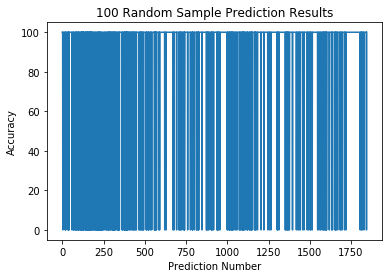

In [18]:
import matplotlib.pyplot as plt



plt.plot(max(totalAvg))
plt.ylabel('Accuracy')
plt.xlabel('Prediction Number')
plt.title('100 Random Sample Prediction Results')
plt.show()

In [16]:
print(np.std(max(totalAvg)))

36.1837537427
